<a href="https://colab.research.google.com/github/prayas99/ME338/blob/main/ME338Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math,os
from numpy.random import choice
import scikitplot as skplt
from time import time

In [ ]:
df = pd.read_csv("/content/drive/My Drive/IITB Sem5/ME 338/Project/data_iterative.csv")

In [ ]:
def roundup(a, digits=4):
    n = 10**-digits
    return round(math.ceil(a / n) * n, digits)

def isEven(num):
    if num%2 ==0:
        return True
    return False

def modLog(num):
    try:
        return log(num)
    except:
        return 0

def loadNumpy(name,path='.'):
    if ".npy" in name:
        fullPath = path+'/'+name
    else:
        fullPath = path+'/'+name+'.npy'
    return np.load(fullPath, allow_pickle=True)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
	'''
	scikit(sklearn) does not have support for mean absolute percentage error MAPE.
	This is because the denominator can theoretically be 0 and so the value would be undefined.
	So this is our implementation
	'''
# 	y_true = check_array(y_true)
# 	y_pred = check_array(y_pred)

	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def r2(y_true,y_pred):
    return roundup(r2_score(y_true,y_pred))

def mse(y_true,y_pred):
    return roundup(mean_squared_error(y_true,y_pred))

def mae(y_true,y_pred):
    return roundup(mean_absolute_error(y_true,y_pred))

def mape(y_true, y_pred):
    return roundup(mean_absolute_percentage_error(y_true,y_pred))

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,ElasticNet
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.validation import check_array 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor

In [ ]:
df.head(10)

,timestep,x_voxel,y_voxel,z_voxel,layerNum,time_creation,x_laser,y_laser,z_laser,x_distance,y_distance,z_distance,euclidean_distance_laser,Tminus1,Tminus2,Tminus3,Tminus4,Tminus5,T1_t-1,T2_t-1,T3_t-1,T4_t-1,T5_t-1,T6_t-1,T7_t-1,T8_t-1,T9_t-1,T10_t-1,T11_t-1,T12_t-1,T13_t-1,T14_t-1,T15_t-1,T16_t-1,T17_t-1,T18_t-1,T19_t-1,T20_t-1,T21_t-1,T22_t-1,T23_t-1,T24_t-1,T25_t-1,T26_t-1,T_self
0,1.0,0.5,1.5,0.5,1.0,2.0,0.0,0.75,0.5,0.5,0.75,0.0,NaN,-99.0,-99.0,-99.0,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.00,-99.00,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,4.00
1,2.0,2.5,1.5,0.5,1.0,0.5,2.6,0.75,0.5,0.1,0.75,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3473.76,3520.21,3993.89,-99.00,-99.0,-99.0,3872.89,-99.00,3519.06,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3549.99
2,2.0,3.0,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.4,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3993.89,2973.47,3553.11,3520.21,-99.0,-99.0,3478.99,3549.99,1614.58,1614.62,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3519.06
3,2.0,2.0,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.6,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3324.64,3478.99,3876.13,3872.89,-99.0,-99.0,3303.29,2329.08,3996.03,3993.89,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3026.39
4,2.0,0.5,1.0,0.5,1.0,0.5,2.6,0.75,0.5,2.1,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,1554.23,2706.98,1643.90,5.00,-99.0,-99.0,1959.09,1763.85,1754.33,2869.67,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,1876.72
5,2.0,3.0,0.0,0.5,1.0,0.5,2.6,0.75,0.5,0.4,0.75,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3996.03,-99.00,-99.00,3553.11,-99.0,-99.0,-99.00,3478.99,-99.00,1614.58,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2975.86
6,2.0,3.0,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.4,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3478.99,1614.58,2975.86,3519.06,-99.0,-99.0,3996.03,3993.89,-99.00,2973.47,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3553.11
7,2.0,3.5,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.9,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3519.06,-99.00,1614.58,1614.62,-99.0,-99.0,3553.11,3520.21,-99.00,-99.00,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,2973.47
8,2.0,2.0,1.0,0.5,1.0,0.5,2.6,0.75,0.5,0.6,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,2329.08,3993.89,3026.39,3473.76,-99.0,-99.0,3324.64,3003.77,3478.99,3549.99,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3872.89
9,2.0,2.5,0.5,0.5,1.0,0.5,2.6,0.75,0.5,0.1,0.25,0.0,NaN,300.0,-99.0,-99.0,-99.0,-99.0,3026.39,3553.11,3996.03,3993.89,-99.0,-99.0,3876.13,3872.89,2975.86,3519.06,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3478.99


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
historicalColumns,neighborColumns,neighborColumnsAggregated = [],[],[]

for historical in range(5):
    historicalColumns += ['Tminus'+str(historical+1)]

for neighbor in range(26):
    neighborColumns += ['T'+str(neighbor+1)+'_t-1']
    
for neighborDegree in range(3):
        neighborColumnsAggregated += ['T_nbhDeg'+str(neighborDegree+1)+'_t-1']

columns = ['voxelLat','voxelLong','voxelVert','voxelType','timestep','x_voxel','y_voxel','z_voxel','layerNum','time_creation', 'time_elapsed', 'x_laser','y_laser','z_laser','x_distance','y_distance','z_distance','euclidean_distance_laser'] + historicalColumns+ neighborColumns + neighborColumnsAggregated + ['T_self']

#featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns
featureColumns = ['timestep','x_distance','y_distance','z_distance','time_elapsed'] + historicalColumns + neighborColumns

featureDisplay = featureColumns

In [ ]:
def plot_feature_importances(et):
    skplt.estimators.plot_feature_importances(et,text_fontsize=16,max_num_features=6,figsize=(24,4),feature_names=featureDisplay)

In [ ]:
df.shape

(1716310, 45)

In [ ]:
df_big = df.copy()
df_big['time_elapsed'] = df_big['timestep'] - df_big['time_creation']
df2 = df_big.sample(10000)
#df2 = df_big.copy()
df_train = df2[df2['timestep'] < 200.0]
df_test = df2[(df2['timestep'] >= 200.0) & (df2['timestep'] < 500.0)]
print('Size of training data :', df_train.shape[0])
print('Size of test data :', df_test.shape[0])
X_train = df_train.loc[:,featureColumns]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

Size of training data : 1723
Size of test data : 8277


0.96
1.5484
CPU times: user 807 ms, sys: 20.4 ms, total: 828 ms
Wall time: 751 ms


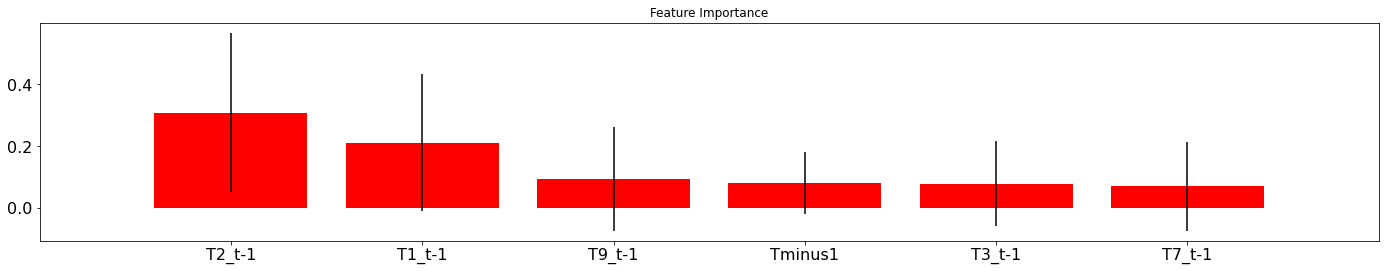

In [ ]:
%%time
et_500 = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=300)
et_500.fit(X_train,y_train)
predicted = et_500.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))
plot_feature_importances(et_500)

# Lin Reg

In [ ]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
predicted = lin_reg.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.8768
8.2465
CPU times: user 8.27 ms, sys: 3.09 ms, total: 11.4 ms
Wall time: 7.05 ms


[]

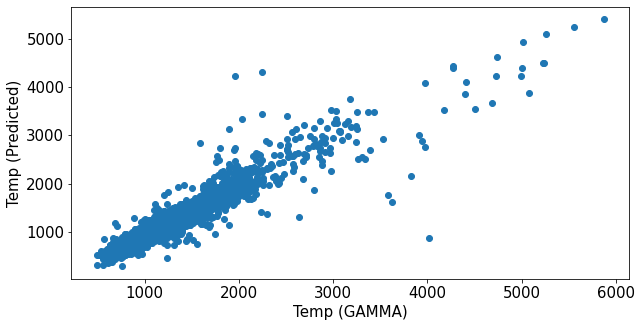

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Lasso Reg

In [ ]:
%%time
clf = linear_model.Lasso(alpha=0.1,tol=1e-1,random_state=300)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.6902
15.4505
CPU times: user 6.81 ms, sys: 3.11 ms, total: 9.92 ms
Wall time: 8.51 ms


[]

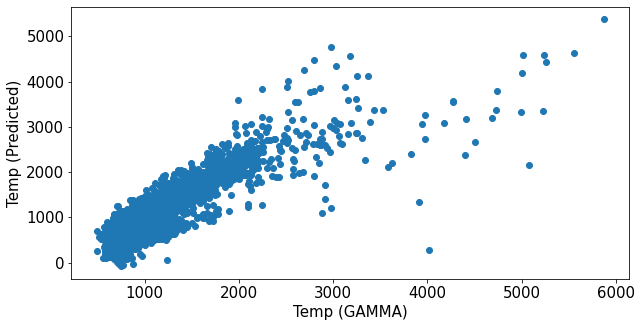

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Ridge Reg

In [ ]:
%%time
ridge = Ridge(alpha=0.1,random_state=300)
ridge.fit(X_train,y_train)
predicted = ridge.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.8782
8.1704
CPU times: user 7.56 ms, sys: 5.21 ms, total: 12.8 ms
Wall time: 10.3 ms


[]

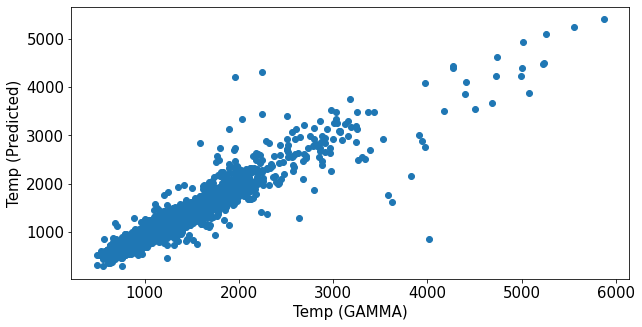

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Decision Tree Regressor

In [ ]:
%%time
dtr = DecisionTreeRegressor(random_state=300)
dtr.fit(X_train,y_train)
predicted = dtr.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.9098
2.6007
CPU times: user 40.2 ms, sys: 115 µs, total: 40.3 ms
Wall time: 40.5 ms


[]

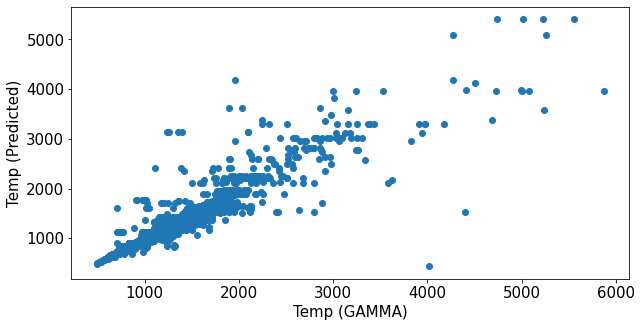

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Ada Boost (best estimators and lr)

In [ ]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
              "n_estimators": [10,20,50,200],
              "learning_rate": [1e-3, 0.01, 0.1, 0.5, 1, 10]
             }         
gr = GridSearchCV(AdaBoostRegressor(),param_grid,cv=5,n_jobs=-1)
gr.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5, 1, 10],
                         'n_estimators': [10, 20, 50, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
gr.best_params_

{'learning_rate': 0.5, 'n_estimators': 20}

In [ ]:
%%time
regr_best = AdaBoostRegressor(random_state=300, n_estimators=20, learning_rate=0.5)
regr_best.fit(X_train,y_train)
predicted = regr_best.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.917
6.1063
CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 181 ms


[]

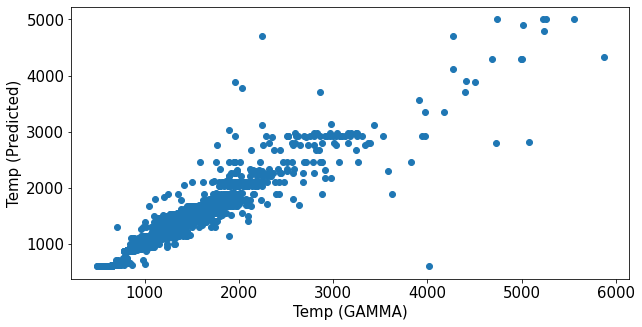

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# XG Boost

In [ ]:
GradientBoostingRegressor().get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_xg = {
              "n_estimators": [20,100,200],
              "learning_rate": [0.1, 0.5],
              "max_depth": [2,4,6],
              'subsample': [0.75,0.9,1.0]
             }         
gr_xg = GridSearchCV(GradientBoostingRegressor(),param_grid_xg,cv=3,n_jobs=4,verbose=5)
gr_xg.fit(X_train,y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   32.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 162 out of 162 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [ ]:
gr_xg.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [ ]:
%%time
xg_best = GradientBoostingRegressor(random_state=300,
                                    n_estimators=100,
                                    learning_rate=0.1,
                                    max_depth = 4,
                                    #subsample = gr_xg.best_params_['subsample'],
                                    )
xg_best.fit(X_train,y_train)
predicted = xg_best.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.9425
2.0514
CPU times: user 1.11 s, sys: 385 µs, total: 1.11 s
Wall time: 1.11 s


[]

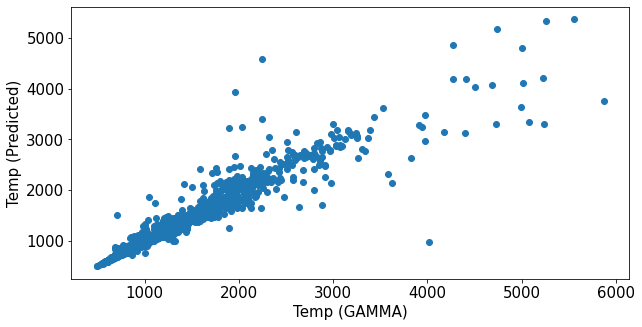

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Random Forest


In [ ]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
              "n_estimators": [10,50,200],
              "learning_rate": [0.1,0.5,1],
              "max_depth": [2,4,6],
              #'max_samples': [0.5,0.75, 1.0],
              'max_features':['auto', 'sqrt', 'log2']             
             }         
gr_rf = GridSearchCV(GradientBoostingRegressor(),param_grid_rf,cv=5,n_jobs=-1,verbose=5)
gr_rf.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [ ]:
gr_rf.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [ ]:
%%time
rf_best = GradientBoostingRegressor(random_state=300,
                                    n_estimators=gr_rf.best_params_['n_estimators'],
                                    learning_rate=gr_rf.best_params_['learning_rate'],
                                    max_depth = gr_rf.best_params_['max_depth'],
                                    #max_samples = gr_rf.best_params_['subsample'],
                                    max_features = gr_rf.best_params_['max_features']
                                    )
rf_best.fit(X_train,y_train)
predicted = rf_best.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.9563
2.673
CPU times: user 125 ms, sys: 1.11 ms, total: 126 ms
Wall time: 128 ms


[]

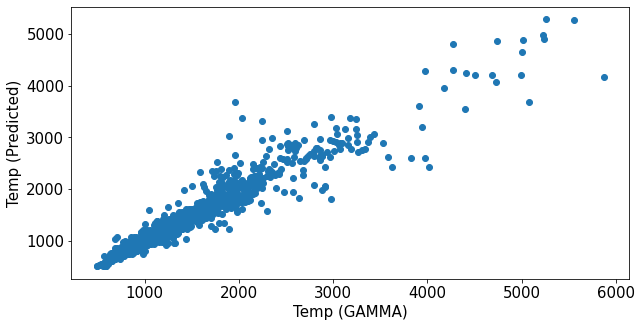

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Extra Trees

In [ ]:
ExtraTreesRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_ERT = {
              "n_estimators": [20,50,200],
              #"learning_rate": [ 0.1,0.5, 2],
              "max_depth": [4, 6 ,8, 10],
              #'max_samples': [0.5,0.75, 1.0],
              'max_features':['auto', 'sqrt', 'log2']
              
             }         
gr_ert = GridSearchCV(ExtraTreesRegressor(),param_grid_ERT,cv=5,n_jobs=-1,verbose=5)
gr_ert.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param

In [ ]:
gr_ert.best_params_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}

In [ ]:
%%time
ERT_best = ExtraTreesRegressor(random_state=300,
                                    n_estimators=gr_ert.best_params_['n_estimators'],
                                    #learning_rate=gr_ert.best_params_['learning_rate'],
                                    max_depth = gr_ert.best_params_['max_depth'],
                                    #max_samples = gr_ert.best_params_['subsample'],
                                    max_features = gr_ert.best_params_['max_features']
                                    )
ERT_best.fit(X_train,y_train)
predicted = ERT_best.predict(X_test)
print(r2(y_test,predicted))
print(mape(y_test,predicted))

0.9605
1.8668
CPU times: user 979 ms, sys: 13.5 ms, total: 993 ms
Wall time: 993 ms


[]

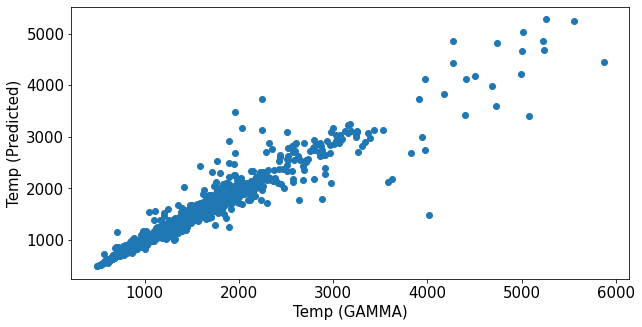

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
plt.scatter(y_test,predicted)
plt.xlabel('Temp (GAMMA)')
plt.ylabel('Temp (Predicted)')
plt.plot()

# Neural Network

In [ ]:
df.shape

(1716310, 45)

In [ ]:
df_big = df.copy()
df_big['time_elapsed'] = df_big['timestep'] - df_big['time_creation']
df2 = df_big.sample(50000)
#df2 = df_big.copy()
df_train = df2[df2['timestep'] < 200.0]
df_test = df2[(df2['timestep'] >= 200.0) & (df2['timestep'] < 500.0)]
print('Size of training data :', df_train.shape[0])
print('Size of test data :', df_test.shape[0])
X_train = df_train.loc[:,featureColumns]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

Size of training data : 8354
Size of test data : 41646


In [ ]:
df2 = df2.fillna(-99.00)
df2.isnull().values.any()
import pandas as pd
from sklearn import preprocessing

x = df2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
0,0.987928,0.700,0.800,1.000000,1.000000,1.000000,0.407641,1.000000,0.923066,0.292359,0.209767,0.000000,0.0,0.215120,0.253082,0.254697,0.249852,0.251127,0.251997,0.234253,0.275929,0.251333,0.446449,0.000000,0.282486,0.253872,0.263813,0.260840,0.412652,0.408162,0.000000,0.000000,0.400272,0.400423,0.000000,0.000000,0.457870,0.416914,0.450068,0.426812,0.000000,0.000000,0.000000,0.000000,0.221590,0.984909
1,0.973843,0.425,0.250,0.333333,0.333333,0.333333,0.757359,0.923077,0.923066,0.332359,0.678968,0.615378,0.0,0.150288,0.184610,0.184868,0.180658,0.181750,0.180888,0.173456,0.172395,0.172222,0.297051,0.175123,0.178361,0.178774,0.167877,0.179780,0.274864,0.300289,0.167794,0.185710,0.287323,0.291689,0.184116,0.176278,0.290065,0.293918,0.283255,0.304118,0.172974,0.177114,0.170370,0.186592,0.155332,0.972837
2,0.327968,0.525,0.350,0.000000,0.000000,0.000000,0.555786,0.307692,0.307689,0.030786,0.012208,0.307689,0.0,0.207050,0.184486,0.186081,0.182163,0.182519,0.503489,0.454841,0.507480,0.467940,0.000000,0.758448,0.478517,0.507262,0.441410,0.451470,0.000000,0.000000,0.891990,0.906711,0.000000,0.000000,0.818481,0.860479,0.000000,0.000000,0.000000,0.000000,0.685919,0.797387,0.843471,0.914443,0.453780,0.327968
3,0.869215,0.475,0.175,0.333333,0.333333,0.333333,0.447359,0.461538,0.923066,0.027641,0.308546,0.615378,0.0,0.202179,0.239408,0.240558,0.235552,0.237235,0.236472,0.223118,0.213505,0.215505,0.373008,0.223910,0.212628,0.216471,0.199759,0.224865,0.324263,0.380898,0.201053,0.240603,0.360939,0.376531,0.242710,0.232443,0.342516,0.372441,0.338753,0.364903,0.210463,0.215754,0.203952,0.227423,0.207907,0.868209
4,0.973843,0.300,0.475,1.000000,1.000000,1.000000,0.757359,0.923077,0.923066,0.457359,0.456715,0.000000,0.0,0.170996,0.206521,0.207327,0.203187,0.205084,0.204120,0.196456,0.194143,0.200288,0.341095,0.000000,0.200341,0.199982,0.187091,0.204322,0.305923,0.329853,0.000000,0.000000,0.325094,0.333027,0.000000,0.000000,0.321506,0.329668,0.321215,0.345386,0.000000,0.000000,0.000000,0.000000,0.176378,0.970825


In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
class CustomDatasetFromCSV(Dataset):
    def __init__(self, data, transform=None):
        self.data = data #torch.FloatTensor(data.values.astype('float'))
        self.transforms = transforms
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        # This method should return only 1 sample and label 
        # (according to "index"), not the whole dataset
        # So probably something like this for you:
        target = self.data.iloc[index,-1]
        data_val = self.data.iloc[index,:-1]
        target = torch.tensor(target,dtype=torch.float32)
        data_val = torch.tensor(data_val,dtype=torch.float32) 
        return data_val,target

    def __len__(self):
        return len(self.data)


dataset = CustomDatasetFromCSV(df2)
batch_size = 32
validation_split = .15
test_split = .15
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor((validation_split+test_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split:], indices[:split//2], indices[split//2:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=test_sampler,drop_last=True)

50000


In [ ]:
class mymodel(torch.nn.Module):
    def __init__(self, D_in, H=4, D_out=1):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(mymodel, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.input_linear(x))
        x = self.output_linear(x)
        #print(x.shape[0])
        return x.view(batch_size)
        # x = x.view(x.shape[0])
        # return x            

In [ ]:
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))
# input,label = iter(train_loader)
# print(input[0].shape)
# next(iter(train_loader))

1093
234
7500


In [ ]:
%%time
D_in = 45; H = 26; D_out = 1
#print(D_in, H, D_out)
model = mymodel(D_in, H, D_out)
#print(model)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
if torch.cuda.is_available():
    model.to('cuda')

step = 0
epochs=50
train_loss_list = []
valid_loss_list = []
train_acc_l = []
val_acc_l = []

for e in range(epochs):
    running_loss_train = 0 
    running_loss_valid = 0
    validation_r2 = 0
    train_r2 = 0


    for inputs, labels in train_loader:

        # Clear the gradients of all optimized tensors
        #print(inputs)
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')   
        else:
            inputs, labels = input, labels        
        # Forward pass
        model.train()
        outputs = model.forward(inputs)
        predicted = outputs.data
        #print(labels,predicted)
        #print(predicted,labels)
    
        #print(predicted,labels)

        training_total += labels.size(0)
                
        train_loss = criterion(outputs, labels)
        train_r2_ =  r2(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())
        #training_correct += r2_loss
        
        #train_acc = training_correct
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Calculate and print running training loss
        running_loss_train += train_loss.item()  
        train_r2 +=  train_r2_

        
    with torch.no_grad():    
            #count=0         
            # Iterate over the entire validation dataset
            for input_images2, labels2 in validation_loader:
                
                # Enable CUDA: use GPUs for model computation
                #count+=1
                #print(count)
                if torch.cuda.is_available():
                    input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                
                # Make predictions 
                outputs2 = model.forward(input_images2)
                predicted2 = outputs2.data
                #print(predicted2,labels2)
                valid_r2_ =  r2(outputs2.detach().cpu().numpy(), labels2.detach().cpu().numpy())
                # Count total and correct predictions
                # validation_total += labels2.size(0)
                # validation_correct += (predicted2 == labels2).sum().item()   
                valid_loss = criterion(outputs2, labels2)
                # val_acc = validation_correct / validation_total
                running_loss_valid += valid_loss.item()  
                validation_r2 +=  valid_r2_
    
    print("Epoch: {}/{}... ".format(e+1, epochs),
          "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
          "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
          "| Train R2: {:.4f}".format(train_r2/len(train_loader)),
          "| Val R2: {:.4f}".format(validation_r2/len(validation_loader)))
    train_loss_list.append(running_loss_train/len(train_loader))
    valid_loss_list.append(running_loss_valid/len(validation_loader))
    train_acc_l.append(train_r2/len(train_loader))
    val_acc_l.append(validation_r2/len(validation_loader))
          
    running_loss_train = 0
    running_loss_valid = 0

Epoch: 1/50...  | Train Loss: 0.0917 | Val Loss: 0.0302 | Train R2: -28.3405 | Val R2: -4.1870
Epoch: 2/50...  | Train Loss: 0.0268 | Val Loss: 0.0238 | Train R2: -2.6662 | Val R2: -1.5590
Epoch: 3/50...  | Train Loss: 0.0212 | Val Loss: 0.0187 | Train R2: -0.9149 | Val R2: -0.4225
Epoch: 4/50...  | Train Loss: 0.0165 | Val Loss: 0.0146 | Train R2: -0.0913 | Val R2: 0.1554
Epoch: 5/50...  | Train Loss: 0.0128 | Val Loss: 0.0112 | Train R2: 0.3409 | Val R2: 0.4827
Epoch: 6/50...  | Train Loss: 0.0098 | Val Loss: 0.0085 | Train R2: 0.5827 | Val R2: 0.6699
Epoch: 7/50...  | Train Loss: 0.0075 | Val Loss: 0.0065 | Train R2: 0.7282 | Val R2: 0.7813
Epoch: 8/50...  | Train Loss: 0.0057 | Val Loss: 0.0049 | Train R2: 0.8185 | Val R2: 0.8504
Epoch: 9/50...  | Train Loss: 0.0043 | Val Loss: 0.0038 | Train R2: 0.8748 | Val R2: 0.8949
Epoch: 10/50...  | Train Loss: 0.0033 | Val Loss: 0.0029 | Train R2: 0.9113 | Val R2: 0.9248
Epoch: 11/50...  | Train Loss: 0.0026 | Val Loss: 0.0022 | Train R2: 0.

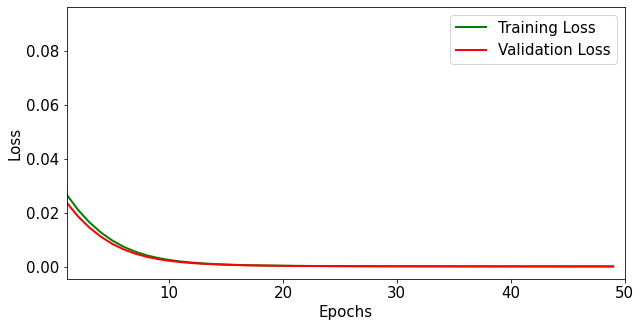

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_loss_list,c='g',label="Training Loss",linewidth=2)
plt.plot(valid_loss_list,c='r',label="Validation Loss",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,50)
plt.legend()
plt.show()

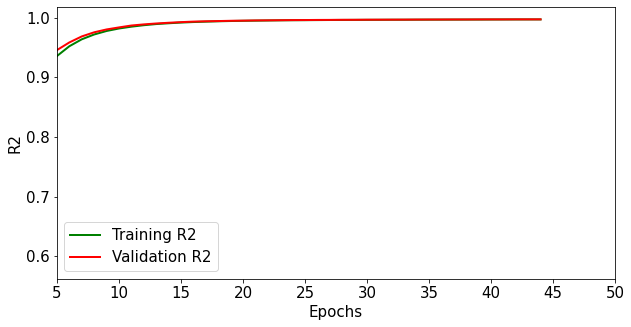

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_acc_l[5:],c='g',label="Training R2",linewidth=2)
plt.plot(val_acc_l[5:],c='r',label="Validation R2",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.xlim(5,50)
plt.legend()
plt.show()

In [ ]:
# %%time
# H_list = [10,20,40,80,100]
# dict_trainL = {}
# dict_valL = {}
# dict_trainAcc={}
# dict_valAcc={}

# for H in H_list:
    
#       D_in = 45; H = H; D_out = 1
#       #print(D_in, H, D_out)
#       model = mymodel(D_in, H, D_out)
#       #print(model)
#       criterion = torch.nn.MSELoss() 
#       optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#       if torch.cuda.is_available():
#           model.to('cuda')

#       step = 0
#       epochs=20
#       train_loss_list = []
#       valid_loss_list = []
#       train_acc_l = []
#       val_acc_l = []

#       for e in range(epochs):
#           running_loss_train = 0 
#           running_loss_valid = 0
#           validation_r2 = 0
#           train_r2 = 0


#           for inputs, labels in train_loader:

#               # Clear the gradients of all optimized tensors
#               #print(inputs)
#               optimizer.zero_grad()
#               if torch.cuda.is_available():
#                   inputs, labels = inputs.to('cuda'), labels.to('cuda')   
#               else:
#                   inputs, labels = input, labels        
#               # Forward pass
#               model.train()
#               outputs = model.forward(inputs)
#               predicted = outputs.data
#               #print(labels,predicted)
#               #print(predicted,labels)
          
#               #print(predicted,labels)

#               training_total += labels.size(0)
                      
#               train_loss = criterion(outputs, labels)
#               train_r2_ =  r2(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())
#               #training_correct += r2_loss
              
#               #train_acc = training_correct
#               # Backward pass
#               train_loss.backward()
#               optimizer.step()
              
#               # Calculate and print running training loss
#               running_loss_train += train_loss.item()  
#               train_r2 +=  train_r2_

              
#           with torch.no_grad():    
#                   #count=0         
#                   # Iterate over the entire validation dataset
#                   for input_images2, labels2 in validation_loader:
                      
#                       # Enable CUDA: use GPUs for model computation
#                       #count+=1
#                       #print(count)
#                       if torch.cuda.is_available():
#                           input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                      
#                       # Make predictions 
#                       outputs2 = model.forward(input_images2)
#                       predicted2 = outputs2.data
#                       #print(predicted2,labels2)
#                       valid_r2_ =  r2(outputs2.detach().cpu().numpy(), labels2.detach().cpu().numpy())
#                       # Count total and correct predictions
#                       # validation_total += labels2.size(0)
#                       # validation_correct += (predicted2 == labels2).sum().item()   
#                       valid_loss = criterion(outputs2, labels2)
#                       # val_acc = validation_correct / validation_total
#                       running_loss_valid += valid_loss.item()  
#                       validation_r2 +=  valid_r2_
          
#           print("Epoch: {}/{}... ".format(e+1, epochs),
#                 "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
#                 "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
#                 "| Train R2: {:.4f}".format(train_r2/len(train_loader)),
#                 "| Val R2: {:.4f}".format(validation_r2/len(validation_loader)))
#           train_loss_list.append(running_loss_train/len(train_loader))
#           valid_loss_list.append(running_loss_valid/len(validation_loader))
#           train_acc_l.append(train_r2/len(train_loader))
#           val_acc_l.append(validation_r2/len(validation_loader))
                
#           running_loss_train = 0
#           running_loss_valid = 0
#       dict_trainL[H] = train_loss_list
#       dict_valL[H] = valid_loss_list
#       dict_trainAcc[H] = train_acc
#       dict_valAcc[H] = val_acc

Epoch: 1/20...  | Train Loss: 0.2146 | Val Loss: 0.0360 | Train R2: -451.1665 | Val R2: -5.8896
Epoch: 2/20...  | Train Loss: 0.0326 | Val Loss: 0.0297 | Train R2: -3.8819 | Val R2: -2.6367
Epoch: 3/20...  | Train Loss: 0.0270 | Val Loss: 0.0243 | Train R2: -1.8411 | Val R2: -1.1828
Epoch: 4/20...  | Train Loss: 0.0219 | Val Loss: 0.0195 | Train R2: -0.7237 | Val R2: -0.3429
Epoch: 5/20...  | Train Loss: 0.0174 | Val Loss: 0.0153 | Train R2: -0.0692 | Val R2: 0.1617
Epoch: 6/20...  | Train Loss: 0.0135 | Val Loss: 0.0117 | Train R2: 0.3320 | Val R2: 0.4724
Epoch: 7/20...  | Train Loss: 0.0102 | Val Loss: 0.0088 | Train R2: 0.5742 | Val R2: 0.6644
Epoch: 8/20...  | Train Loss: 0.0077 | Val Loss: 0.0066 | Train R2: 0.7252 | Val R2: 0.7800
Epoch: 9/20...  | Train Loss: 0.0057 | Val Loss: 0.0049 | Train R2: 0.8199 | Val R2: 0.8530
Epoch: 10/20...  | Train Loss: 0.0043 | Val Loss: 0.0038 | Train R2: 0.8769 | Val R2: 0.8980
Epoch: 11/20...  | Train Loss: 0.0033 | Val Loss: 0.0030 | Train R2:

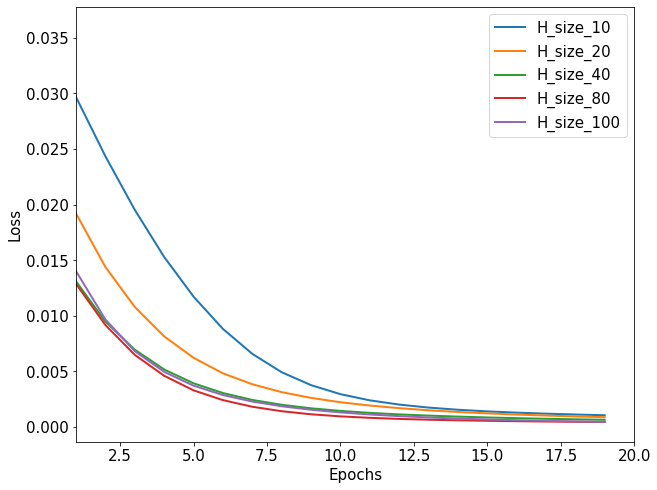

In [ ]:
# H_list = [10,20,40,80,100]
# plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(10,8))
# for i in range(5):
#     # train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
#     # valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
#     plt.plot(dict_valL[H_list[i]],label="H_size_" + str(H_list[i]),linewidth=2)
#     #plt.plot(val_acc_l,c='r',label="Validation Acc",linewidth=2)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.xlim(1,20)
# plt.legend()
# plt.show()

#Iterative

In [ ]:
df_big = df.copy()
df_big['time_elapsed'] = df_big['timestep'] - df_big['time_creation']
df2 = df_big.sample(30000)
#df2 = df_big.copy()
df_train = df2[df2['timestep'] < 200.0]
df_test = df2[(df2['timestep'] >= 200.0) & (df2['timestep'] < 500.0)]
print('Size of training data :', df_train.shape[0])
print('Size of test data :', df_test.shape[0])
X_train = df_train.loc[:,featureColumns]
y_train = df_train['T_self']

X_test = df_test.loc[:,featureColumns]
y_test = df_test['T_self']

X_train,y_train = shuffle(X_train,y_train,random_state=300)
X_test,y_test = shuffle(X_test,y_test,random_state=300)

Size of training data : 5041
Size of test data : 24959


In [ ]:
df_big = df2.copy()
df_train_1 = df_big[df_big.timestep < 200.0]
df_test_1 = df_big[(df_big.timestep >= 200.0) & (df_big.timestep < 220.0)]

# featureColumns = ['timestep','x_distance','y_distance','z_distance','layerNum','Tminus1','Tminus2']+neighborColumns

X_train_1, y_train_1= shuffle(df_train_1.loc[:,featureColumns ], df_train_1['T_self'].values, random_state=300)
X_test_1,y_test_1 = shuffle(df_test_1.loc[:,featureColumns],df_test_1['T_self'],random_state=300)

et_1 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_1.fit(X_train_1,y_train_1)
y_predicted_1 = et_1.predict(X_test_1)
print('Iteration 1 over....')

X_train_2, y_train_2= X_train_1.append(X_test_1, ignore_index=True), np.append( y_train_1, y_predicted_1)
X_train_2,y_train_2 = shuffle(X_train_2,y_train_2,random_state=300)

df_test_2 = df_big[(df_big.timestep >= 220.0) & (df_big.timestep < 240.0)]
X_test_2,y_test_2 = shuffle(df_test_2.loc[:,featureColumns],df_test_2['T_self'],random_state=300)

et_2 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_2.fit(X_train_2,y_train_2)
y_predicted_2 = et_2.predict(X_test_2)
print('Iteration 2 over....')

X_train_3, y_train_3= X_train_2.append(X_test_2, ignore_index=True), np.append( y_train_2, y_predicted_2)
X_train_3,y_train_3 = shuffle(X_train_3,y_train_3,random_state=300)

df_test_3 = df_big[(df_big.timestep >= 240.0) & (df_big.timestep < 260.0)]
X_test_3,y_test_3 = shuffle(df_test_3.loc[:,featureColumns],df_test_3['T_self'],random_state=300)

et_3 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_3.fit(X_train_3,y_train_3)
y_predicted_3 = et_3.predict(X_test_3)
print('Iteration 3 over....')

X_train_4, y_train_4= X_train_3.append(X_test_3, ignore_index=True), np.append( y_train_3, y_predicted_3)
X_train_4,y_train_4 = shuffle(X_train_4,y_train_4,random_state=300)

df_test_4 = df_big[(df_big.timestep >= 260.0) & (df_big.timestep < 280.0)]
X_test_4,y_test_4 = shuffle(df_test_4.loc[:,featureColumns],df_test_4['T_self'],random_state=300)

et_4 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_4.fit(X_train_4,y_train_4)
y_predicted_4 = et_4.predict(X_test_4)
print('Iteration 4 over....')

X_train_5, y_train_5= X_train_4.append(X_test_4, ignore_index=True), np.append( y_train_4, y_predicted_4)
X_train_5,y_train_5 = shuffle(X_train_5,y_train_5,random_state=300)

df_test_5 = df_big[(df_big.timestep >= 280.0) & (df_big.timestep < 300.0)]
X_test_5,y_test_5 = shuffle(df_test_5.loc[:,featureColumns],df_test_5['T_self'],random_state=300)

et_5 = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_5.fit(X_train_5,y_train_5)
y_predicted_5 = et_5.predict(X_test_5)
print('Iteration 5 over....')


print ('Iterative training results')
print (r2(y_test_1,y_predicted_1), mape(y_test_1,y_predicted_1))
print (r2(y_test_2,y_predicted_2), mape(y_test_2,y_predicted_2))
print (r2(y_test_3,y_predicted_3), mape(y_test_3,y_predicted_3))
print (r2(y_test_4,y_predicted_4), mape(y_test_4,y_predicted_4))
print (r2(y_test_5,y_predicted_5), mape(y_test_5,y_predicted_5))

print ('One step training results')
et_direct = ExtraTreesRegressor(n_estimators=10, n_jobs=-1,random_state=300)
et_direct.fit(X_train_1,y_train_1)
y_predicted = et_direct.predict(X_test_5)

r2(y_test_5,y_predicted) ,mape(y_test_5,y_predicted)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iterative training results
0.9547 1.9304
0.9601 1.8178
0.9492 2.9099
0.9579 1.7542
0.9642 1.9935
One step training results


(0.9543, 2.1509)

In [ ]:
def compare_iterative_direct_prediction(n=5, init=100, TIMESTEP_ITER = 50, n_estimators=10):
    
    df_train_i_minus_1 = df_big[df_big.timestep < init]
    df_test_i_minus_1 = df_big[(df_big.timestep >= init) & (df_big.timestep < init+TIMESTEP_ITER)]
#     print (df_test_i_minus_1)

    X_train_i_minus_1, y_train_i_minus_1= shuffle(df_train_i_minus_1.loc[:,featureColumns ], df_train_i_minus_1['T_self'].values, random_state=300)
    X_test_i_minus_1,y_test_i_minus_1 = shuffle(df_test_i_minus_1.loc[:,featureColumns],df_test_i_minus_1['T_self'],random_state=300)

    et_i_minus_1 = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
    start = time()
    et_i_minus_1.fit(X_train_i_minus_1,y_train_i_minus_1)
    y_predicted_i_minus_1 = et_i_minus_1.predict(X_test_i_minus_1)
    
    START = init
    STOP = init + TIMESTEP_ITER
    
#     print ("START is: ",START)
#     print ("STOP is: ", STOP)
    
#     print ("r2 is: ",r2(y_test_i_minus_1,y_predicted_i_minus_1) , "mape is: ", mape(y_test_i_minus_1,y_predicted_i_minus_1))
    
    temp_y = y_test_i_minus_1
    temp_predicted = y_predicted_i_minus_1

    print('Iteration 1 over....')
#     print('\n')
    
    
    for i in range(2,n+1):
        X_train_i, y_train_i= X_train_i_minus_1.append(X_test_i_minus_1, ignore_index=True), np.append(y_train_i_minus_1, y_predicted_i_minus_1)
#         print(X_train_i.iloc[:,0:2].tail(50))
#         print(X_train_i_minus_1.iloc[:,0:2].tail(50))
        X_train_i,y_train_i = shuffle(X_train_i,y_train_i,random_state=300)
        START = START + TIMESTEP_ITER
        STOP = STOP + TIMESTEP_ITER
#         print ("START is: ",START)
#         print ("STOP is: ", STOP)
        df_test_i = df_big[(df_big.timestep >= START) & (df_big.timestep < STOP)]
#         print (df_test_i)
        X_test_i,y_test_i = shuffle(df_test_i.loc[:,featureColumns],df_test_i['T_self'],random_state=300)

        et_i = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
        et_i.fit(X_train_i,y_train_i)
        y_predicted_i = et_i.predict(X_test_i)
#         print ("r2 is: ", r2(y_test_i,y_predicted_i),"mape is: ",mape(y_test_i,y_predicted_i))
        
        temp_y = temp_y.append(y_test_i)
        temp_predicted = np.append(temp_predicted,y_predicted_i)
        
        X_train_i_minus_1 = X_train_i
        X_test_i_minus_1 = X_test_i
        y_train_i_minus_1 = y_train_i
#         y_test_i_minus_1 = y_test_i
        y_predicted_i_minus_1 = y_predicted_i
        
        print('Iteration '+str(i)+' over....')
#         print('\n')
#         if i==2:
#             break

    stop = time()
#     print ('time elapsed for iterative is ',(stop-start),'seconds')
#     print ('\n')

#     print (r2(y_test_i,y_predicted_i) ,mape(y_test_i,y_predicted_i))

    print('\n')
    print ('Iterative Prediction Accuracy for all timesteps predicted: ')
    
#     print (temp_y)
#     print (temp_predicted)
    
#     print (len(temp_y),len(temp_predicted))
    
    print ("r2 is: ", r2(temp_y,temp_predicted) ,"mape is: ", mape(temp_y,temp_predicted))    
    print('\n')
    

    print ('Non-iterative accuracy for last TIME_STEP_ITER timesteps: ')
    df_train_1 = df_big[df_big.timestep < init]
    X_train_1, y_train_1= shuffle(df_train_1.loc[:,featureColumns ], df_train_1['T_self'].values, random_state=300)
    start = time()
    et_direct = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
    et_direct.fit(X_train_1,y_train_1)
    y_predicted_direct = et_direct.predict(X_test_i)

    stop = time()
#     print ('time elapsed for direct is ',(stop-start),'seconds')
    print ("r2 is: ", r2(y_test_i,y_predicted_direct), "mape is: ", mape(y_test_i,y_predicted_direct))
    print('\n')

    
    
    print ('Non-iterative accuracy for all timesteps predicted: ')
    
    df_train = df_big[df_big['timestep'] < init]
    df_test = df_big[(df_big['timestep'] >= init) & (df_big['timestep'] < (init+ (TIMESTEP_ITER * n) ))]


    X_train = df_train.loc[:,featureColumns]
    y_train = df_train['T_self']

    X_test = df_test.loc[:,featureColumns]
    y_test = df_test['T_self']

    X_train,y_train = shuffle(X_train,y_train,random_state=300)
    X_test,y_test = shuffle(X_test,y_test,random_state=300)
    
    et_direct = ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1,random_state=300)
    et_direct.fit(X_train,y_train)
    predicted = et_direct.predict(X_test)
    print ("r2 is: ", r2(y_test,predicted), "mape is: ", mape(y_test,predicted))

In [ ]:
compare_iterative_direct_prediction(n=10,init=200,TIMESTEP_ITER=6,n_estimators=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....


Iterative Prediction Accuracy for all timesteps predicted: 
r2 is:  0.9683 mape is:  1.7772


Non-iterative accuracy for last TIME_STEP_ITER timesteps: 
r2 is:  0.9507 mape is:  4.335


Non-iterative accuracy for all timesteps predicted: 
r2 is:  0.9592 mape is:  2.4981


In [ ]:
compare_iterative_direct_prediction(n=20,init=200,TIMESTEP_ITER=6,n_estimators=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....


Iterative Prediction Accuracy for all timesteps predicted: 
r2 is:  0.9654 mape is:  1.9319


Non-iterative accuracy for last TIME_STEP_ITER timesteps: 
r2 is:  0.9509 mape is:  2.6861


Non-iterative accuracy for all timesteps predicted: 
r2 is:  0.959 mape is:  2.4033


In [ ]:
compare_iterative_direct_prediction(n=30,init=200,TIMESTEP_ITER=6,n_estimators=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....


Iterative Prediction Accuracy for all timesteps predicted: 
r2 is:  0.9614 mape is:  1.7034


Non-iterative accuracy for last TIME_STEP_ITER timesteps: 
r2 is:  0.9981 mape is:  0.5096


Non-iterative accuracy for all timesteps predicted: 
r2 is:  0.955 mape is:  2.0503


In [ ]:
compare_iterative_direct_prediction(n=40,init=200,TIMESTEP_ITER=6,n_estimators=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....
Iteration 31 over....
Iteration 32 over....
Iteration 33 over....
Iteration 34 over....
Iteration 35 over....
Iteration 36 over....
Iteration 37 over....
Iteration 38 over....
Iteration 39 over....
Iteration 40 over....


Iterative Prediction Accuracy for all timesteps predicted: 
r2 is:  0.9628 mape is:  1.6676


Non-iterative accuracy for last T

In [ ]:
compare_iterative_direct_prediction(n=50,init=200,TIMESTEP_ITER=6,n_estimators=10)

Iteration 1 over....
Iteration 2 over....
Iteration 3 over....
Iteration 4 over....
Iteration 5 over....
Iteration 6 over....
Iteration 7 over....
Iteration 8 over....
Iteration 9 over....
Iteration 10 over....
Iteration 11 over....
Iteration 12 over....
Iteration 13 over....
Iteration 14 over....
Iteration 15 over....
Iteration 16 over....
Iteration 17 over....
Iteration 18 over....
Iteration 19 over....
Iteration 20 over....
Iteration 21 over....
Iteration 22 over....
Iteration 23 over....
Iteration 24 over....
Iteration 25 over....
Iteration 26 over....
Iteration 27 over....
Iteration 28 over....
Iteration 29 over....
Iteration 30 over....
Iteration 31 over....
Iteration 32 over....
Iteration 33 over....
Iteration 34 over....
Iteration 35 over....
Iteration 36 over....
Iteration 37 over....
Iteration 38 over....
Iteration 39 over....
Iteration 40 over....
Iteration 41 over....
Iteration 42 over....
Iteration 43 over....
Iteration 44 over....
Iteration 45 over....
Iteration 46 over..